In [87]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Word2vec
import gensim

# Utility
import re
import string
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [102]:
# DATASET
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# WORD2VEC 
W2V_SIZE = 320
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 320
EPOCHS = 50
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [140]:
dataset_path = "F:\VU\Web_Data_Processing_Systems\clean_kindle_reviews.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING ,lineterminator='\n')
df = df.drop(columns=["Unnamed: 0"])

Open file: F:\VU\Web_Data_Processing_Systems\clean_kindle_reviews.csv


In [141]:
print("Dataset size:", len(df))

Dataset size: 982619


In [136]:
df.head(10)

,asin,overall,reviewText,summary\r
878051,B00JB0MYS6,5,"This book reveals the basics of tinnitus, you ...",Great introduction!\r
4007,B0026REA92,4,Intriguing start to a series about a once-burn...,"hot, intriguing\r"
822366,B00IC4QIZC,1,Crude nightmarish fiction with constant explet...,Mindless Thrash\r
917025,B00K2LXIKG,5,Liked the history and the love story. I loved ...,Good book!\r
918572,B00K3RZXOS,5,This book was good can't wait for part two thi...,Hittaz wear pink\r
844319,B00IOCZI4O,5,Absolutely enchanting. Very smoothly written. ...,You Were Always There\r
554312,B00DFG6NHK,5,Another cliffhanger!!! Omg I need book 8 now.....,Shockingly seductive\r
324654,B009OZN608,5,Forgotten Lyrics is the perfect novella to int...,Perfect Novella and Intro to the Watersong Ser...
35632,B004DUN1W2,3,"Look guys, people don't often just ""move on"" w...",Average Romance with Interesting Premise\r
150390,B006LFQA52,2,Memoir of a young animal lover who was determi...,"Author focuses on herself, not the animals\r"


In [142]:
decode_map = {1: "NEGATIVE", 2: "NEGATIVE", 3: "NEUTRAL", 4: "POSITIVE", 5: "POSITIVE" }
def decode_sentiment(label):
    return decode_map[int(label)]

In [143]:
%%time
df.overall = df.overall.apply(lambda x: decode_sentiment(x))

Wall time: 1.15 s


Text(0.5, 1.0, 'Dataset labels distribuition')

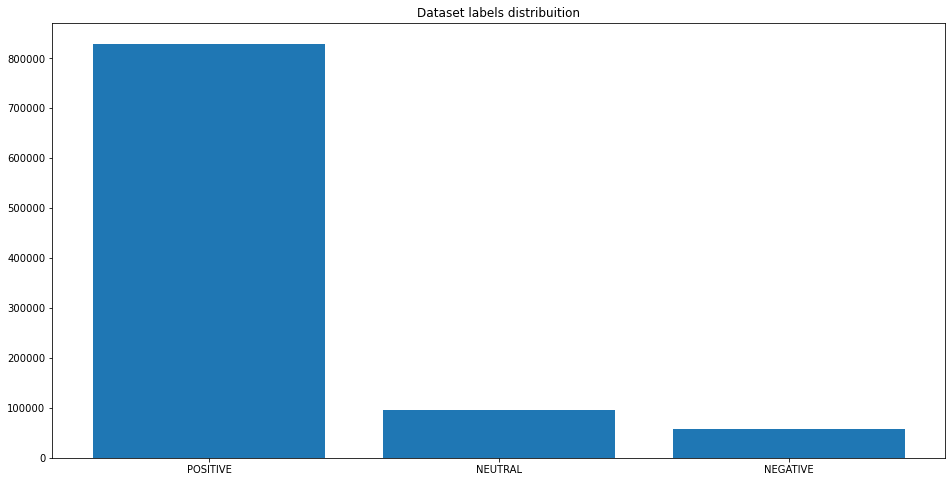

In [144]:
target_cnt = Counter(df.overall)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [33]:
df.reviewText.head(10)

664870    Love the characters! A little too tame for me....
713916    THIS BOOK WAS AMAZING!!! VERY WELL WRITTEN, PI...
413126    Have not tried this yet but plan to self publi...
442248    This story is okay it wasn't enough informatio...
219519    Definitely loved it a lot!!!!!!!! The story in...
434975    I enjoyed this story. Colleen Coble is an exce...
636481    Buy. This. Book. Now.What more is there to say...
543420    If you love suspense and adventure then you'll...
790238    From reading this book, I can confidently say ...
389914    I'm just going to go ahead and get the biggest...
Name: reviewText, dtype: object

In [34]:
# split train, test data 
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 16000
TEST size: 4000


In [35]:
df_train.head()

,asin,overall,reviewText,summary\r
489064,B00C9FTZ5U,NEUTRAL,2.5-3 stars - An okay read. Your mileage will ...,Had some issues...\r
844534,B00IODNJRG,POSITIVE,I could not put this book down. I loved it!! ...,loved this book!!!! amazing\r
235681,B0086OEU4E,NEUTRAL,This story was very short. She works for and ...,"SHORT, CUTE\r"
320051,B009M4YYZW,POSITIVE,"I really liked this author, I had never read h...",Hot Alpha\r
544058,B00D6OE8SW,POSITIVE,Thank you kindly to the author for giving me a...,Intriguing little tale...\r


In [37]:
# tokenization
documents = [_text.split() for _text in df_train.reviewText]

In [38]:
# cleaning token
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token

# processing
def process_token(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        # Eliminating the token if it is not characters in English
        token = re.sub("([^A-Za-z0-9_]+)","", token)
        
        cleaned_token = cleaned(token.lower())
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation: 
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

In [39]:
print(documents[4])

['Thank', 'you', 'kindly', 'to', 'the', 'author', 'for', 'giving', 'me', 'a', 'copy', 'of', 'this', 'novella', 'for', 'review.When', 'branch', 'manager', 'Giles', 'Macintosh', 'arrives', 'to', 'open', 'up', 'one', 'morning', 'and', 'finds', 'an', 'injured', 'bum', 'and', 'his', 'battered', 'dog', 'lying', 'in', 'the', 'doorway', 'of', 'the', 'bank,', 'he', 'little', 'suspects', 'what', 'lies', 'in', 'store', 'for', 'them', 'all.This', 'was', 'a', 'quirky', 'and', 'intriguing', 'little', 'story', '-', 'my', 'one', 'complaint', 'is', 'that', 'I', 'would', 'have', 'liked', 'it', 'to', 'be', 'longer..it', 'felt', 'like', 'a', 'novel', 'in', 'the', 'making.', 'Thats', 'not', 'a', 'bad', 'thing', 'incidentally,', 'it', 'meant', 'that', 'I', 'would', 'happily', 'have', 'read', 'on....Its', 'a', 'bit', 'difficult', 'to', 'put', 'this', 'one', 'in', 'a', 'genre', 'box.', 'It', 'was', 'a', 'fairly', 'gritty', 'read', 'whilst', 'also', 'having', 'a', 'heart', 'warming', 'message', 'at', 'its', 'h

In [40]:
print(process_token(documents[4]))

['thank', 'you', 'kindly', 'to', 'the', 'author', 'for', 'giving', 'me', 'a', 'copy', 'of', 'this', 'novella', 'for', 'reviewwhen', 'branch', 'manager', 'giles', 'macintosh', 'arrives', 'to', 'open', 'up', 'one', 'morning', 'and', 'finds', 'an', 'injured', 'bum', 'and', 'his', 'battered', 'dog', 'lying', 'in', 'the', 'doorway', 'of', 'the', 'bank', 'he', 'little', 'suspects', 'what', 'lies', 'in', 'store', 'for', 'them', 'allthis', 'was', 'a', 'quirky', 'and', 'intriguing', 'little', 'story', 'my', 'one', 'complaint', 'is', 'that', 'i', 'would', 'have', 'liked', 'it', 'to', 'be', 'longerit', 'felt', 'like', 'a', 'novel', 'in', 'the', 'making', 'thats', 'not', 'a', 'bad', 'thing', 'incidentally', 'it', 'meant', 'that', 'i', 'would', 'happily', 'have', 'read', 'onits', 'a', 'bit', 'difficult', 'to', 'put', 'this', 'one', 'in', 'a', 'genre', 'box', 'it', 'was', 'a', 'fairly', 'gritty', 'read', 'whilst', 'also', 'having', 'a', 'heart', 'warming', 'message', 'at', 'its', 'heart', 'and', 'an

In [41]:
cleaned_documents = [process_token(document) for document in documents]

In [42]:
print(cleaned_documents[4])

['thank', 'you', 'kindly', 'to', 'the', 'author', 'for', 'giving', 'me', 'a', 'copy', 'of', 'this', 'novella', 'for', 'reviewwhen', 'branch', 'manager', 'giles', 'macintosh', 'arrives', 'to', 'open', 'up', 'one', 'morning', 'and', 'finds', 'an', 'injured', 'bum', 'and', 'his', 'battered', 'dog', 'lying', 'in', 'the', 'doorway', 'of', 'the', 'bank', 'he', 'little', 'suspects', 'what', 'lies', 'in', 'store', 'for', 'them', 'allthis', 'was', 'a', 'quirky', 'and', 'intriguing', 'little', 'story', 'my', 'one', 'complaint', 'is', 'that', 'i', 'would', 'have', 'liked', 'it', 'to', 'be', 'longerit', 'felt', 'like', 'a', 'novel', 'in', 'the', 'making', 'thats', 'not', 'a', 'bad', 'thing', 'incidentally', 'it', 'meant', 'that', 'i', 'would', 'happily', 'have', 'read', 'onits', 'a', 'bit', 'difficult', 'to', 'put', 'this', 'one', 'in', 'a', 'genre', 'box', 'it', 'was', 'a', 'fairly', 'gritty', 'read', 'whilst', 'also', 'having', 'a', 'heart', 'warming', 'message', 'at', 'its', 'heart', 'and', 'an

In [61]:
# word 2 vec
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [62]:
w2v_model.build_vocab(documents)

2020-12-01 11:02:43,668 : INFO : collecting all words and their counts
2020-12-01 11:02:43,671 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-01 11:02:44,580 : INFO : PROGRESS: at sentence #10000, processed 1108622 words, keeping 78636 word types
2020-12-01 11:02:45,266 : INFO : collected 107612 word types from a corpus of 1773065 raw words and 16000 sentences
2020-12-01 11:02:45,268 : INFO : Loading a fresh vocabulary
2020-12-01 11:02:45,513 : INFO : effective_min_count=10 retains 9657 unique words (8% of original 107612, drops 97955)
2020-12-01 11:02:45,515 : INFO : effective_min_count=10 leaves 1601566 word corpus (90% of original 1773065, drops 171499)
2020-12-01 11:02:45,679 : INFO : deleting the raw counts dictionary of 107612 items
2020-12-01 11:02:45,689 : INFO : sample=0.001 downsamples 57 most-common words
2020-12-01 11:02:45,691 : INFO : downsampling leaves estimated 1176382 word corpus (73.5% of prior 1601566)
2020-12-01 11:02:45,824 : IN

In [63]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 9657


In [64]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-12-01 11:03:21,337 : INFO : training model with 8 workers on 9657 vocabulary and 320 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-12-01 11:03:22,425 : INFO : EPOCH 1 - PROGRESS: at 19.67% examples, 217937 words/s, in_qsize 15, out_qsize 0
2020-12-01 11:03:23,426 : INFO : EPOCH 1 - PROGRESS: at 42.00% examples, 239486 words/s, in_qsize 16, out_qsize 0
2020-12-01 11:03:24,460 : INFO : EPOCH 1 - PROGRESS: at 64.04% examples, 244563 words/s, in_qsize 16, out_qsize 2
2020-12-01 11:03:25,479 : INFO : EPOCH 1 - PROGRESS: at 89.76% examples, 257320 words/s, in_qsize 15, out_qsize 0
2020-12-01 11:03:25,761 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 11:03:25,773 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 11:03:25,777 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 11:03:25,779 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 11:03:25,782 : INFO 

2020-12-01 11:03:52,958 : INFO : EPOCH 7 - PROGRESS: at 37.00% examples, 209012 words/s, in_qsize 16, out_qsize 0
2020-12-01 11:03:53,993 : INFO : EPOCH 7 - PROGRESS: at 57.44% examples, 217654 words/s, in_qsize 16, out_qsize 0
2020-12-01 11:03:55,012 : INFO : EPOCH 7 - PROGRESS: at 74.30% examples, 211641 words/s, in_qsize 16, out_qsize 2
2020-12-01 11:03:55,998 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 11:03:56,006 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 11:03:56,010 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 11:03:56,017 : INFO : EPOCH 7 - PROGRESS: at 97.82% examples, 224155 words/s, in_qsize 4, out_qsize 1
2020-12-01 11:03:56,020 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 11:03:56,033 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-01 11:03:56,051 : INFO : worker thread finished; awaiting finish of 2 more threads

2020-12-01 11:04:24,898 : INFO : EPOCH 13 - PROGRESS: at 84.43% examples, 235143 words/s, in_qsize 16, out_qsize 0
2020-12-01 11:04:25,567 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 11:04:25,581 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 11:04:25,591 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 11:04:25,612 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 11:04:25,648 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-01 11:04:25,653 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-01 11:04:25,660 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-01 11:04:25,673 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-01 11:04:25,675 : INFO : EPOCH - 13 : training on 1773065 raw words (1176626 effective words) took 5.0s, 235549 effective words/s
2020-12-01 11:04:26

2020-12-01 11:04:55,764 : INFO : EPOCH 19 - PROGRESS: at 90.41% examples, 258814 words/s, in_qsize 16, out_qsize 1
2020-12-01 11:04:56,030 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 11:04:56,041 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 11:04:56,070 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 11:04:56,079 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 11:04:56,082 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-01 11:04:56,089 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-01 11:04:56,105 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-01 11:04:56,109 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-01 11:04:56,114 : INFO : EPOCH - 19 : training on 1773065 raw words (1176052 effective words) took 4.5s, 263864 effective words/s
2020-12-01 11:04:57

2020-12-01 11:05:26,793 : INFO : EPOCH 25 - PROGRESS: at 74.82% examples, 214830 words/s, in_qsize 15, out_qsize 0
2020-12-01 11:05:27,788 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 11:05:27,793 : INFO : EPOCH 25 - PROGRESS: at 96.66% examples, 223062 words/s, in_qsize 6, out_qsize 1
2020-12-01 11:05:27,795 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 11:05:27,799 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 11:05:27,803 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 11:05:27,836 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-01 11:05:27,850 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-01 11:05:27,887 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-01 11:05:27,915 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-01 11:05:27,918 : INFO : EPOCH - 25

2020-12-01 11:05:56,675 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 11:05:56,686 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 11:05:56,731 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 11:05:56,739 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 11:05:56,761 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-01 11:05:56,764 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-01 11:05:56,768 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-01 11:05:56,811 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-01 11:05:56,813 : INFO : EPOCH - 31 : training on 1773065 raw words (1175916 effective words) took 4.7s, 249311 effective words/s
2020-12-01 11:05:57,833 : INFO : EPOCH 32 - PROGRESS: at 19.45% examples, 229614 words/s, in_qsize 15, out_qsize 0
2020-12-01 11:05:58

Wall time: 2min 40s


(37649595, 56738080)

In [65]:
# Tokenize Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.reviewText)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 41187


In [66]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.reviewText), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.reviewText), maxlen=SEQUENCE_LENGTH)

In [67]:
# Label encoder
labels = df_train.overall.unique().tolist()
labels

['NEUTRAL', 'POSITIVE', 'NEGATIVE']

In [94]:
encoder = LabelEncoder()
encoder.fit(df_train.overall.tolist())

y_train = encoder.transform(df_train.overall.tolist())
y_test = encoder.transform(df_test.overall.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (16000, 320)
y_train (16000, 1)
x_test (4000, 320)
y_test (4000, 1)


In [69]:
# Embedding Layer
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(41187, 320)


In [127]:
#Build Model
model = Sequential()
model.add(Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(0.5))
model.add(LSTM(160, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 320, 320)          13179840  
_________________________________________________________________
dropout_6 (Dropout)          (None, 320, 320)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 80)                128320    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 81        
Total params: 13,308,241
Trainable params: 128,401
Non-trainable params: 13,179,840
_________________________________________________________________


In [131]:
# Compile model
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [132]:
# Callbacks
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [133]:
# Train
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 14400 samples, validate on 1600 samples
Epoch 1/50
14400/14400 [==============================] - 448s 31ms/step - loss: -2.4569 - accuracy: 0.0969 - val_loss: -6.5490 - val_accuracy: 0.0994
Epoch 2/50
14400/14400 [==============================] - 387s 27ms/step - loss: -7.4679 - accuracy: 0.0969 - val_loss: -9.5285 - val_accuracy: 0.0994
Epoch 3/50
14400/14400 [==============================] - 425s 29ms/step - loss: -10.2119 - accuracy: 0.0969 - val_loss: -11.2418 - val_accuracy: 0.0994
Epoch 4/50
 1024/14400 [=>............................] - ETA: 4:58 - loss: -11.5396 - accuracy: 0.0811

KeyboardInterrupt: 

In [104]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

4000/4000 [==============================] - 23s 6ms/step

ACCURACY: 0.8445000052452087
LOSS: 0.6003175930976867


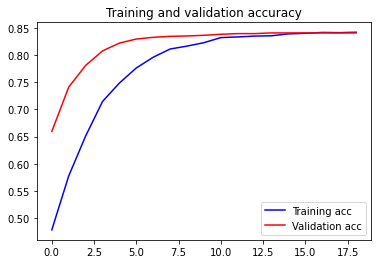

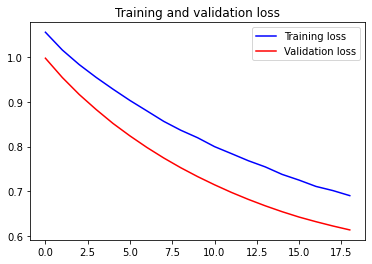

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [109]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [110]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [126]:
text = "I love the music"
x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
score = model.predict([x_test])

print(score)

[[0.16761859 0.30697802 0.7972239 ]]


In [111]:
predict("I love the music")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [62]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.4831560254096985,
 'elapsed_time': 0.07238101959228516}

In [63]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.021119922399520874,
 'elapsed_time': 0.08184218406677246}

In [64]:
predict("Bad guys")

{'label': 'NEGATIVE',
 'score': 0.08120599389076233,
 'elapsed_time': 0.07676076889038086}

In [65]:
predict("fuck u all")

{'label': 'NEGATIVE',
 'score': 0.25452369451522827,
 'elapsed_time': 0.07674908638000488}

In [66]:
predict("I'm going under and this time I fear there's no one to save me")

{'label': 'NEGATIVE',
 'score': 0.3585672676563263,
 'elapsed_time': 0.07496809959411621}

In [45]:
#Save model
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-11-28 23:00:56,152 : INFO : saving Word2Vec object under model.w2v, separately None
2020-11-28 23:00:56,153 : INFO : not storing attribute vectors_norm
2020-11-28 23:00:56,154 : INFO : not storing attribute cum_table
2020-11-28 23:00:56,537 : INFO : saved model.w2v


In [67]:
model.save("model_epoc3.h5")